# UNET workbench
A test notebook to evaluate a basic UNET for segmentation

In [5]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, concatenate

import matplotlib.pyplot as plt
import numpy as np

# Fetch images

The test data is from the [EPFL CVLAB data repository](https://www.epfl.ch/labs/cvlab/data/data-em/).
Download the images from 
![](FIBSLICE0035_left_top.png)
||Input| Ground truth|
|---|---|---|
|Training|[Training](https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif)|[Training ground truth](https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif)|
|Testing|[Testing](https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing.tif)|[Testing ground truth](https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing_groundtruth.tif)|

# Prepare images for training
The images are stored as multi frame tiff and are too large for our demo.
We have to:
- load some frames. E.g. every 10 images. 
- crop to realistic size


In [6]:
from PIL import Image

def crop_and_convert(tiff_path, dest_mask,first=0, step=1, crop_box=None) :
    
    tiff_image = Image.open(tiff_path)

    # Iterate through each frame
    frame_number = first
    filelist = []
    while True:
        try:
            tiff_image.seek(frame_number)
            # Process the current frame
            
            # For example, you can save each frame as a separate image
            fname = dest_mask.format(frame_number)
            filelist.append(fname)
            
            if crop_box is None :
                tiff_image.save(fname)
            else :
                cropped_frame = tiff_image.crop(crop_box)
                # Save the cropped frame
                cropped_frame.save(fname)
            
            frame_number += step
        except EOFError:
            # No more frames in the TIFF file
            break
    return filelist
            


In [7]:
train_image_paths = crop_and_convert('training.tif', 'training_{0:04d}.png',step=10,crop_box=[256,256,768,768])
train_mask_paths  = crop_and_convert('training_groundtruth.tif', 'trainingGT_{0:04d}.png',step=10,crop_box=[256,256,768,768])

validation_image_paths = crop_and_convert('training.tif', 'validation_{0:04d}.png',step=20,crop_box=[512,256,768,512])
validation_mask_paths  = crop_and_convert('training_groundtruth.tif', 'validationGT_{0:04d}.png',step=20,crop_box=[512,256,768,512])

In [8]:
N=256

In [9]:
def parse_image_function(image_path, mask_path, img_size=(N, N), channels=1):
    # Load and preprocess the input image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=channels)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32)
    
    mean, variance = tf.nn.moments(image, axes=[0, 1, 2])  # or other relevant axes
    std = tf.sqrt(variance)
    image = (image - mean) / (std + 1e-8)

    # Load and preprocess the corresponding mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
    mask = tf.cast(mask, tf.float32) / 255.0  # For binary masks
    return image, mask

In [10]:
def predict_segmentation(model, image_path, img_size=(N,N), threshold=None):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32)
    mean, variance = tf.nn.moments(image, axes=[0, 1, 2])  # or other relevant axes
    std = tf.sqrt(variance)
    image = (image - mean) / (std + 1e-8)
    image = tf.expand_dims(image, axis=0)  # add batch dimension

    pred_mask = model.predict(image)[0]
    # For binary segmentation, threshold the prediction
    if threshold is not None:
        pred_mask = (pred_mask > threshold).astype("uint8")
    return pred_mask

In [11]:
def conv_block(x, filters,M=3,repeats=2):
    """
    A basic convolution block: two 3x3 convolutions with ReLU activation.
    """
    for i in range(repeats):
        x = tf.keras.layers.Conv2D(filters, (M,M), activation='relu', padding='same')(x)
    
    return x

## First model

In [82]:
# Suppose you have lists of image and mask file paths:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(lambda img, msk: parse_image_function(img, msk),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [83]:
from tensorflow.keras import layers, models

def unet_model(input_shape=(N, N, 1), num_classes=1):
    inputs = layers.Input(input_shape)
    
    M = 5
    # Encoder
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)

    # Decoder
    u2 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c3)
    u2 = layers.concatenate([u2, c2])
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c4)

    u1 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c4)
    u1 = layers.concatenate([u1, c1])
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c5)

    # Output layer: for binary segmentation use a sigmoid; for multi-class, use softmax
    outputs = layers.Conv2D(num_classes, (1,1), activation='sigmoid')(c5)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and compile the model
model = unet_model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # change loss if needed (e.g., categorical_crossentropy for multi-class)
              metrics=['accuracy'])

model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 256, 256,  │        640 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 256, 256,  │     36,928 │ conv2d_99[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 128, 128,  │          0 │ conv2d_100[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 128, 128,  │     73,856 │ max_pooling2d_18… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 128, 128,  │    147,584 │ conv2d_101[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 64, 64,    │          0 │ conv2d_102[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 64, 64,    │    295,168 │ max_pooling2d_19… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 64, 64,    │    590,080 │ conv2d_103[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_18 │ (None, 128, 128,  │    131,200 │ conv2d_104[0][0]  │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_102[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 128, 128,  │    295,040 │ concatenate_18[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 128, 128,  │    147,584 │ conv2d_105[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_19 │ (None, 256, 256,  │     32,832 │ conv2d_106[0][0]  │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_100[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 256, 256,  │     73,792 │ concatenate_19[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 256, 256,  │     36,928 │ conv2d_107[0][0]

 Total params: 1,861,697 (7.10 MB)

 Trainable params: 1,861,697 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

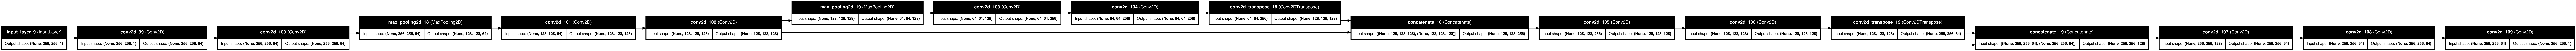

In [84]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your TensorFlow/Keras model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR')



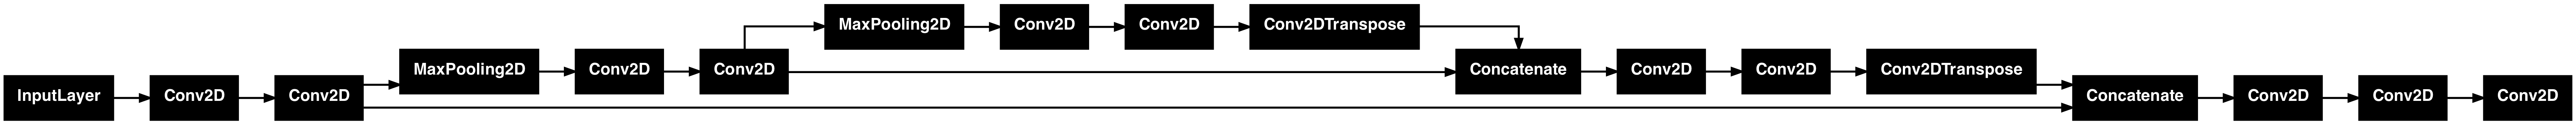

In [85]:
plot_model(model,
           to_file='model_reduced.png',
           show_shapes=False,      # Hide output shapes
           show_layer_names=False, # Hide layer names
  rankdir='LR')           # Layout from left-to-right

In [86]:


validation_dataset = tf.data.Dataset.from_tensor_slices((validation_image_paths, validation_mask_paths))
validation_dataset = validation_dataset.map(lambda img, msk: parse_image_function(img, msk),
                                  num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [87]:
# Train the model
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)  # Ensure you have a validation dataset prepared similarly

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - accuracy: 0.0911 - loss: 0.7148 - val_accuracy: 0.9003 - val_loss: 0.6017
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.9412 - loss: 0.5797 - val_accuracy: 0.9003 - val_loss: 0.6554
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.9412 - loss: 0.3440 - val_accuracy: 0.9003 - val_loss: 0.2908
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9412 - loss: 0.1878 - val_accuracy: 0.9003 - val_loss: 0.2453
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9412 - loss: 0.1693 - val_accuracy: 0.9003 - val_loss: 0.2239
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9412 - loss: 0.1441 - val_accuracy: 0.9003 - val_loss: 0.2079
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9412 - loss: 0.1400 - val_accuracy: 0.9003 - val_loss: 0.1891
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.9412 - loss: 0.1274 - val_accuracy: 0.9003 - val_loss:

In [2]:
from tensorflow.keras.utils import plot_model

plot_model(model,
           to_file='model_reduced.png',
           show_shapes=False,      # Hide output shapes
           show_layer_names=False, # Hide layer names
  rankdir='LR')           # Layout from left-to-right

NameError: name 'model' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


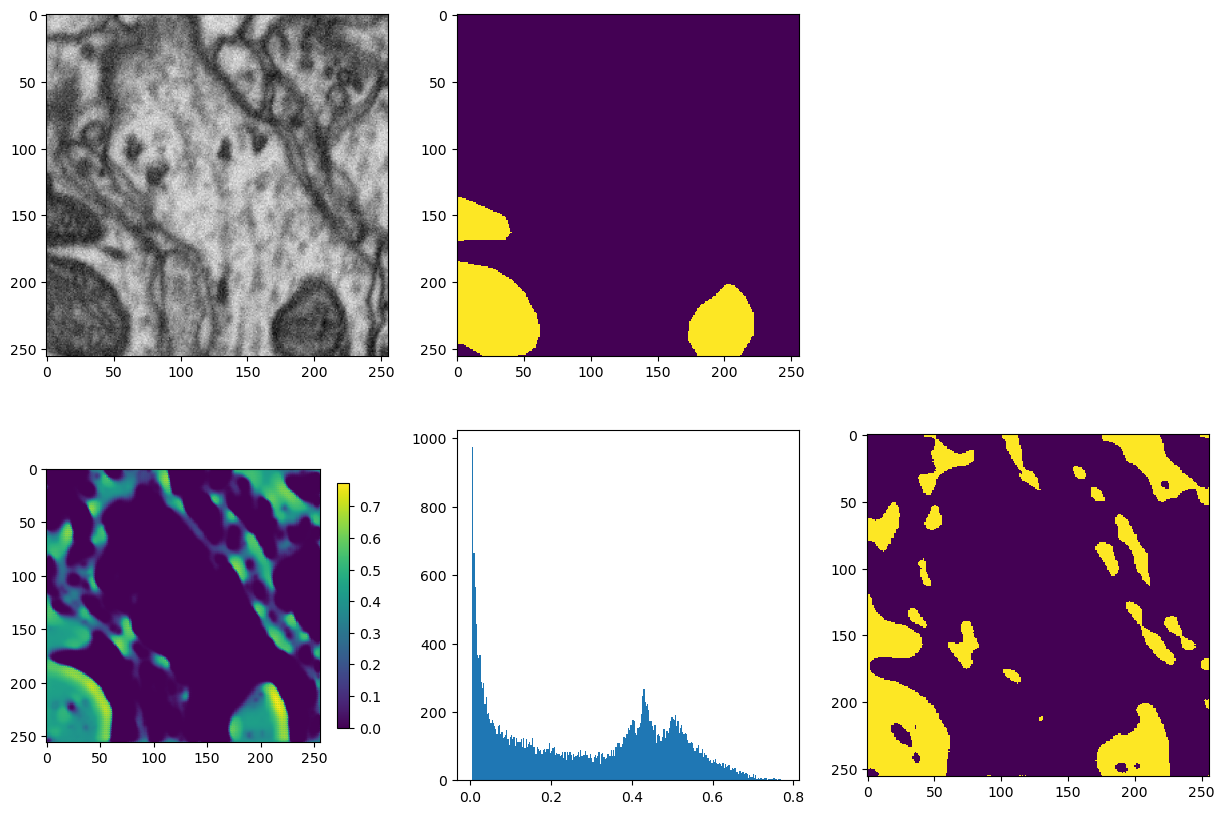

In [89]:
# Example usage:
idx = 0
imgname = 'validation_{0:04d}.png'.format(idx)
valname = 'validationGT_{0:04d}.png'.format(idx)
predicted_mask = predict_segmentation(model, imgname,threshold=None)

fig,ax= plt.subplots(2,3,figsize=(15,10))
ax=ax.ravel();

img=plt.imread(imgname)
mask = plt.imread(valname)
ax[0].imshow(img,cmap='gray')
ax[1].imshow(mask,interpolation='none')
ax[2].axis('off')
aa=ax[3].imshow(predicted_mask,interpolation='none',cmap='viridis')
fig.colorbar(aa, ax=ax[3], shrink=0.7)
ax[4].hist(predicted_mask[predicted_mask>0.005].ravel(),bins=256);
ax[5].imshow(predicted_mask>0.35, interpolation='none')

# Deeper U-nets

In [12]:
N=256

In [13]:

def unet_2d_4levels(input_shape=(N, N, 1), base_filters=32):
    inputs = tf.keras.Input(shape=input_shape)

    M=5
    repeats = 3
    # Encoder: 4 levels
    c1 = conv_block(inputs, base_filters,M=M, repeats=repeats)            # Level 1
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, base_filters * 2,M=M, repeats=repeats)            # Level 2
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

    c3 = conv_block(p2, base_filters * 4,M=M, repeats=repeats)            # Level 3
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

    c4 = conv_block(p3, base_filters * 8,M=M, repeats=repeats)            # Level 4 (bottom)

    # Decoder
    u3 = tf.keras.layers.Conv2DTranspose(base_filters * 4, 
                                         (2,2), strides=(2,2),
                                         padding='same')(c4)
    u3 = tf.keras.layers.concatenate([u3, c3])
    c5 = conv_block(u3, base_filters * 4,M=M, repeats=repeats)

    u2 = tf.keras.layers.Conv2DTranspose(base_filters * 2,
                                         (2,2), strides=(2,2),
                                         padding='same')(c5)
    u2 = tf.keras.layers.concatenate([u2, c2])
    c6 = conv_block(u2, base_filters * 2,M=M, repeats=repeats)

    u1 = tf.keras.layers.Conv2DTranspose(base_filters,
                                         (2,2), strides=(2,2),
                                         padding='same')(c6)
    u1 = tf.keras.layers.concatenate([u1, c1])
    c7 = conv_block(u1, base_filters,M=M, repeats=repeats)

    # Output: single channel, sigmoid activation
    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c7)
    model = tf.keras.Model(inputs, outputs)
    return model

def unet_2d_5levels(input_shape=(N, N, 1), base_filters=32):
    """
    A 5-level U-Net architecture.
    """

    inputs = tf.keras.Input(shape=input_shape)

    # -------------------------
    # Encoder (5 levels)
    # -------------------------
    c1 = conv_block(inputs, base_filters)             # Level 1
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, base_filters * 2)             # Level 2
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

    c3 = conv_block(p2, base_filters * 4)             # Level 3
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

    c4 = conv_block(p3, base_filters * 8)             # Level 4
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

    # Bottom (Level 5)
    c5 = conv_block(p4, base_filters * 16)            # Level 5 (bottom)

    # -------------------------
    # Decoder
    # -------------------------
    # From Level 5 to Level 4
    u4 = tf.keras.layers.Conv2DTranspose(base_filters * 8, 
                                         (2,2), strides=(2,2),
                                         padding='same')(c5)
    u4 = tf.keras.layers.concatenate([u4, c4])
    c6 = conv_block(u4, base_filters * 8)

    # From Level 4 to Level 3
    u3 = tf.keras.layers.Conv2DTranspose(base_filters * 4,
                                         (2,2), strides=(2,2),
                                         padding='same')(c6)
    u3 = tf.keras.layers.concatenate([u3, c3])
    c7 = conv_block(u3, base_filters * 4)

    # From Level 3 to Level 2
    u2 = tf.keras.layers.Conv2DTranspose(base_filters * 2,
                                         (2,2), strides=(2,2),
                                         padding='same')(c7)
    u2 = tf.keras.layers.concatenate([u2, c2])
    c8 = conv_block(u2, base_filters * 2)

    # From Level 2 to Level 1
    u1 = tf.keras.layers.Conv2DTranspose(base_filters,
                                         (2,2), strides=(2,2),
                                         padding='same')(c8)
    u1 = tf.keras.layers.concatenate([u1, c1])
    c9 = conv_block(u1, base_filters)

    # Output: single channel, sigmoid activation (for binary segmentation)
    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    # Create the model
    model = tf.keras.Model(inputs, outputs)
    return model

## Reload data to match new model

### Training

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(lambda img, msk: parse_image_function(img, msk,img_size=(N, N), channels=1),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

2025-03-15 17:00:53.129785: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-03-15 17:00:53.129868: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-03-15 17:00:53.129875: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1742054453.129918 3783549 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742054453.129966 3783549 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Validation

In [15]:
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_image_paths, validation_mask_paths))
validation_dataset = validation_dataset.map(lambda img, msk: parse_image_function(img, msk, img_size=(N, N), channels=1),
                                  num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

## Build and train the model

In [16]:
# Instantiate and compile the model
model = unet_2d_4levels(base_filters=64)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
# #               optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
#               loss=['binary_crossentropy','dice'],  # change loss if needed (e.g., categorical_crossentropy for multi-class)
#               metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=[
#                     'mse',
                    'binary_crossentropy',
#                      'dice'
                   ],  # change loss if needed (e.g., categorical_crossentropy for multi-class)
              metrics=[
                  'binary_accuracy', 
                  'mae',
#                    tf.keras.metrics.BinaryIoU()
                  tf.keras.metrics.AUC(),
#                   tf.keras.metrics.F1Score(threshold=0.5)
              ])

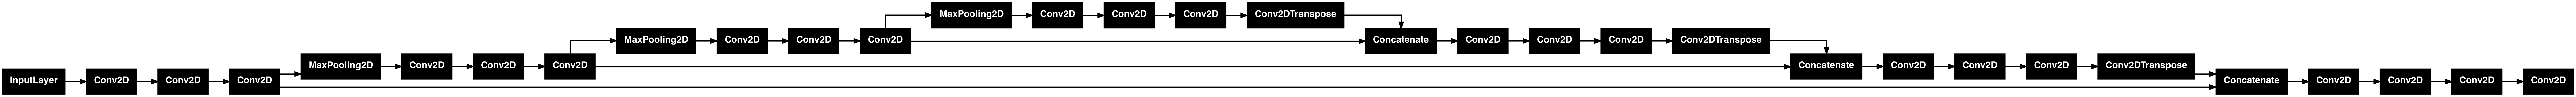

In [17]:
from tensorflow.keras.utils import plot_model

plot_model(model,
           to_file='model_reduced.png',
           show_shapes=False,      # Hide output shapes
           show_layer_names=False, # Hide layer names
  rankdir='LR')           # Layout from left-to-right

In [ ]:
# Train the model
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)  # Ensure you have a validation dataset prepared similarly

Epoch 1/20


2025-03-15 17:01:16.955417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - auc: 0.3961 - binary_accuracy: 0.9397 - loss: 0.6765 - mae: 0.4899 - val_auc: 0.3057 - val_binary_accuracy: 0.9003 - val_loss: 0.4532 - val_mae: 0.3417
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 864ms/step - auc: 0.2982 - binary_accuracy: 0.9412 - loss: 0.4043 - mae: 0.3129 - val_auc: 0.7873 - val_binary_accuracy: 0.9003 - val_loss: 0.2931 - val_mae: 0.2108
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - auc: 0.8109 - binary_accuracy: 0.9412 - loss: 0.2360 - mae: 0.1789 - val_auc: 0.9065 - val_binary_accuracy: 0.9003 - val_loss: 0.2369 - val_mae: 0.1612
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - auc: 0.9092 - binary_accuracy: 0.9412 - loss: 0.1720 - mae: 0.1227 - val_auc: 0.9300 - val_binary_accuracy: 0.9003 - val_loss: 0.2225 - val_mae: 0.1310
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - auc: 0.9258 - binary_accuracy: 0.9412 - loss: 0.1462 - mae: 0.0884 - val_auc: 0.9378 - val_binary_accuracy: 0.9003 - val_loss: 0.2148 - val_mae: 0.1227
Epo

In [ ]:
# Example usage:
idx = 0
imgname = 'validation_{0:04d}.png'.format(idx)
valname = 'validationGT_{0:04d}.png'.format(idx)
predicted_mask = predict_segmentation(model, imgname,threshold=None)

fig,ax= plt.subplots(2,3,figsize=(15,10))
ax=ax.ravel();

img=plt.imread(imgname)
mask = plt.imread(valname)
ax[0].imshow(img,cmap='gray')
ax[1].imshow(mask,interpolation='none')
ax[2].axis('off')
aa=ax[3].imshow(predicted_mask,interpolation='none',cmap='gray')
fig.colorbar(aa, ax=ax[3], shrink=0.7)
ax[4].hist(predicted_mask[predicted_mask>0.02].ravel(),bins=256);
ax[5].imshow(predicted_mask>0.38, interpolation='none')

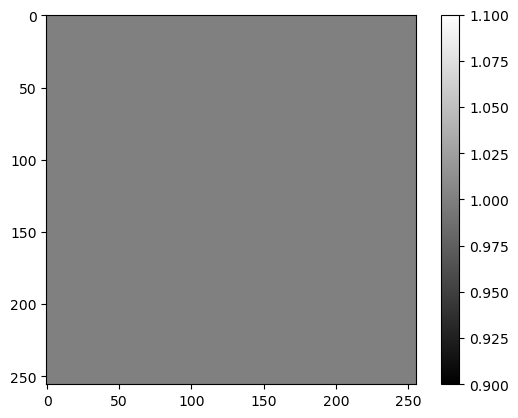

In [217]:
plt.imshow(predicted_mask>0.08,interpolation='none',cmap='gray')
plt.colorbar()

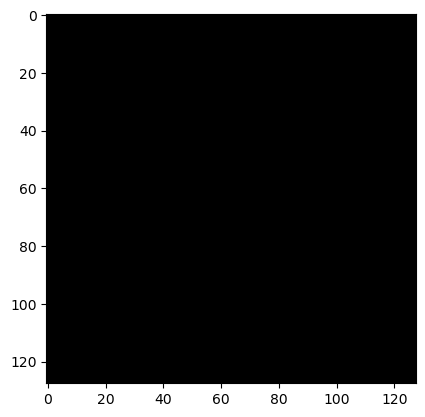

In [82]:
plt.imshow(predicted_mask<0.505,interpolation='none',cmap='gray')

## From lecture 2020

In [83]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, concatenate


In [102]:
def lecture_model(input_shape=(128,128,1),base_depth=32) :
    inputs = tf.keras.Input(shape=input_shape)
#     in_img = Input(input_shape, name='Image_Input')
#     c1 = conv_block(inputs, base_filters)
    lay_1 = Conv2D(base_depth, kernel_size=(3, 3), padding='same')(inputs)
    lay_2 = Conv2D(base_depth, kernel_size=(3, 3), padding='same')(lay_1)
    lay_3 = MaxPool2D((2, 2))(lay_2)
    lay_4 = Conv2D(base_depth*2, kernel_size=(3, 3), padding='same')(lay_3)
    lay_5 = Conv2D(base_depth*2, kernel_size=(3, 3), padding='same')(lay_4)
    lay_6 = MaxPool2D((2, 2))(lay_5)
    lay_7 = Conv2D(base_depth*4, kernel_size=(3, 3), padding='same')(lay_6)
    lay_8 = Conv2D(base_depth*4, kernel_size=(3, 3), padding='same')(lay_7)
    lay_9 = UpSampling2D((2, 2))(lay_8)
    lay_10 = concatenate([lay_5, lay_9])
    lay_11 = Conv2D(base_depth*2, kernel_size=(3, 3), padding='same')(lay_10)
    lay_12 = Conv2D(base_depth*2, kernel_size=(3, 3), padding='same')(lay_11)
    lay_13 = UpSampling2D((2, 2))(lay_12)
    lay_14 = concatenate([lay_2, lay_13])
    lay_15 = Conv2D(base_depth, kernel_size=(3, 3), padding='same')(lay_14)
    lay_16 = Conv2D(base_depth, kernel_size=(3, 3), padding='same')(lay_15)
    lay_17 = Conv2D(1, kernel_size=(1, 1), padding='same',
                    activation='sigmoid')(lay_16)
    t_unet = Model(inputs=[inputs], outputs=[lay_17], name='SmallUNET')
    
    return t_unet

In [103]:
t_unet = lecture_model()
t_unet.summary()

Model: "SmallUNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_238 (Conv2D) │ (None, 128, 128,  │        320 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_239 (Conv2D) │ (None, 128, 128,  │      9,248 │ conv2d_238[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_46    │ (None, 64, 64,    │          0 │ conv2d_239[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_240 (Conv2D) │ (None, 64, 64,    │     18,496 │ max_pooling2d_46… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_241 (Conv2D) │ (None, 64, 64,    │     36,928 │ conv2d_240[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_47    │ (None, 32, 32,    │          0 │ conv2d_241[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_242 (Conv2D) │ (None, 32, 32,    │     73,856 │ max_pooling2d_47… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_243 (Conv2D) │ (None, 32, 32,    │    147,584 │ conv2d_242[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_20    │ (None, 64, 64,    │          0 │ conv2d_243[0][0]  │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_46      │ (None, 64, 64,    │          0 │ conv2d_241[0][0], │
│ (Concatenate)       │ 192)              │            │ up_sampling2d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_244 (Conv2D) │ (None, 64, 64,    │    110,656 │ concatenate_46[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_245 (Conv2D) │ (None, 64, 64,    │     36,928 │ conv2d_244[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_21    │ (None, 128, 128,  │          0 │ conv2d_245[0][0]  │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_47      │ (None, 128, 128,  │          0 │ conv2d_239[0][0], │
│ (Concatenate)       │ 96)               │            │ up_sampling2d_21… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_246 (Conv2D) │ (None, 128, 128,  │     27,680 │ concatenate_47[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_247 (Conv2D) │ (None, 128, 128,  │      9,248 │ conv2d_246[0][0]

 Total params: 470,977 (1.80 MB)

 Trainable params: 470,977 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
model = t_unet(input_shape=(N,N,1),base_depth=32)
model.compile(#optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
              loss=['mse'],  # change loss if needed (e.g., categorical_crossentropy for multi-class)
              metrics=['binary_accuracy', 'mae'])

TypeError: missing a required argument: 'inputs'